## Imports
---

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

import random
random.seed(42)

import warnings
warnings.filterwarnings("ignore")

### Definitions
---

In [2]:
def class_metrics(X_train, y_train, X_test, y_test, model):
    """
    This Function takes in X, and y train 
    test data and prints out three metrics
    that we want to optimize for.
    """
    #Training metrics
    y_preds_train = model.predict(X_train)
    sens_tr = recall_score(y_train, y_preds_train, pos_label=1)
    spec_tr = recall_score(y_train, y_preds_train, pos_label=0)
    train_acc = model.score(X_train, y_train)
    
    #Test metrics
    y_preds_test = model.predict(X_test)
    sens_tst = recall_score(y_test, y_preds_test, pos_label=1)
    spec_tst = recall_score(y_test, y_preds_test, pos_label=0)
    test_acc = model.score(X_test , y_test)
    
    print('Train Accuracy - Correctly Classified:', round(train_acc,2))
    print('Test Accuracy - Correctly Classified:', round(test_acc,2))
    
    print('\nTrain Sensitivity - True Positvive Rate:', round(sens_tr,2))
    print('Test Sensitivity - True Positvive Rate:', round(sens_tst,2))
    
    print('\nTrain Specificity - True Negative Rate:', round(spec_tr,2))
    print('Test Specificity - True Negative Rate:', round(spec_tst,2))
    print('\nConfustion Matrix of Test Data')
    plot_confusion_matrix(model, X_test, y_test, cmap='BuPu', values_format='d')

In [3]:
#Read in csv of feature selected from EDA notbook.
df = pd.read_csv('../Data/2018_gov_features.csv', index_col='Unnamed: 0')

#Dropping two features which we will include in our further iterations.
df.drop(columns=['ownhome', 'pid3'], inplace=True)
df.head()

,dist,gender,age,educ,race,faminc,marstat,newsint,approval_gov,ideo5,voted_gov
392782,19,Female,54,4-Year,White,50k - 60k,Single / Never Married,Most of the time,Strongly Approve,Liberal,[Democrat / Candidate 1]
392786,52,Female,28,Some College,White,20k - 30k,Single / Never Married,Most of the time,Strongly Approve,Liberal,[Democrat / Candidate 1]
392800,49,Male,86,Post-Grad,White,120k - 150k,Widowed,Most of the time,Strongly Disapprove,Very Conservative,[Republican / Candidate 2]
392832,36,Male,80,Some College,White,20k - 30k,Widowed,Most of the time,Strongly Disapprove,Conservative,[Republican / Candidate 2]
392860,36,Male,83,4-Year,White,Prefer not to say,Married,Most of the time,Strongly Disapprove,Conservative,[Republican / Candidate 2]


#### Feature Engineer the target column.

Well define our target to be the 'voted_gov' column. well have edit this feature for modeling..

In [4]:
# Value counts funtion shows we have more then 2 options for our target.
df['voted_gov'].value_counts()

[Democrat / Candidate 1]       2287
[Republican / Candidate 2]     1376
I Did Not Vote In This Race      37
Not Sure                         25
Other                            14
Name: voted_gov, dtype: int64

In [5]:
# Drop the other, not sure, and I did not vote classes in this race.
df = df[(df['voted_gov'] == '[Democrat / Candidate 1]') | (df['voted_gov'] == '[Republican / Candidate 2]')]

After some debate whether to encode the non Republican or Democrat catagroies and include in our target, we decided to drop them. The reasoning for this is that these categories represent around 3% of our target data, we feel that this is a heavily underrepresented class and our classification models wouldn't be able to classify them with any accuracy. Also, the purpose of this project is to accurately predict whether a Republican or Democrat would win the election we don't see these votes having an effect on our classification.

#### Dummify Catagorical Columns

In [6]:
# Use pd.get_dummies to dummify the catagoricalcolums.
df = pd.get_dummies(df, columns=['gender', 'educ', 'race', 'faminc', 'marstat', 'newsint', 'approval_gov','ideo5'], drop_first=True)

#### Create Target column.

In [7]:
# Catagorize our Target column to have the voted for democrat to be our positive class.
df['voted_gov'] = df['voted_gov'].map({'[Democrat / Candidate 1]': 1, '[Republican / Candidate 2]': 0})

# Relabling our target colum to signify the positive class is voting republican.
df.rename(columns={'voted_gov': 'voted_democrat'}, inplace=True)

In [8]:
# Create X and y variables
X = df.drop(columns=['voted_democrat'])
y = df['voted_democrat']

# Create a train test split with a 30% test size.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.3)

### Grid Search: Logistic Regression / Knn / Niave Baise
---

Performed thre gridsearches to find the best hyperparameters. We took those hyperparameters and added them to our final voting classifer, we used these models in order for our coefficients to be interpretable. Perhapes, if the models where interpretable, more value could be gained from their interpretation.

In [9]:
# Scale our data for a logistic regression model
lr_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression()),
])

# Find the optimal hyperparameters.
pipe_params ={
    'lr__C' : [1.0, 0.1, 0.01, 0.001],
    'lr__penalty': ['l1','l2','none'],

}

# Gridsearch using the specified hyper parameters.
grid_model = GridSearchCV(
    lr_pipe,
    pipe_params,
    cv = 5,
    n_jobs = -1,
    verbose = 2
)

# Fit our training data to the Grisearch.
grid_model.fit(X_train, y_train)
print(grid_model.best_params_)
print(grid_model.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'lr__C': 0.1, 'lr__penalty': 'l2'}
Pipeline(steps=[('ss', StandardScaler()), ('lr', LogisticRegression(C=0.1))])


Train Accuracy - Correctly Classified: 0.92
Test Accuracy - Correctly Classified: 0.91

Train Sensitivity - True Positvive Rate: 0.95
Test Sensitivity - True Positvive Rate: 0.95

Train Specificity - True Negative Rate: 0.88
Test Specificity - True Negative Rate: 0.85

Confustion Matrix of Test Data


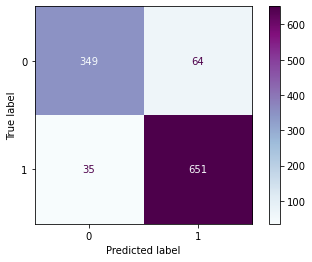

In [10]:
class_metrics(X_train, y_train, X_test,y_test, grid_model)

These results seem very good starting out, not very overfit, due to regularization, as well as very good sinsitivity 95%. lets try KNN and see the results imporve the goal is to have a voting classifer using three interpretable models.

In [11]:
# Create a pipleline to scale our data fro KNN Classification.
lr_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier()),
])


# find the optimal hyperparameters.
pipe_params ={
    'knn__n_neighbors' : [1 ,2, 3, 4, 5, 6, 7],
}

# Create a gridsearch model to find our Hyperparameters
grid_model = GridSearchCV(
    lr_pipe,
    pipe_params,
    cv = 5,
    n_jobs = -1,
    verbose = 2
)


# Fit our training data to the Grisearch.
grid_model.fit(X_train, y_train)
print(grid_model.best_params_)
print(grid_model.best_estimator_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'knn__n_neighbors': 7}
Pipeline(steps=[('ss', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=7))])


Train Accuracy - Correctly Classified: 0.9
Test Accuracy - Correctly Classified: 0.85

Train Sensitivity - True Positvive Rate: 0.94
Test Sensitivity - True Positvive Rate: 0.91

Train Specificity - True Negative Rate: 0.84
Test Specificity - True Negative Rate: 0.75

Confustion Matrix of Test Data


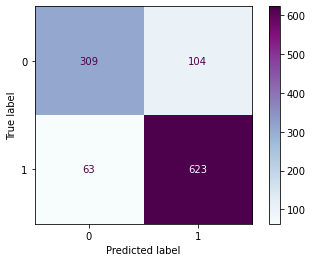

In [12]:
class_metrics(X_train, y_train, X_test,y_test, grid_model)

In the above KNN model. The Train-Test accuracy spread of 90% and 85% seem to show some overfitting and a lot of misclassification in predicting the negative class. we will now run a Naive Baise model and evaluate the results.

In [13]:
# find the optimal hyperparameters.
grid_params ={
    'alpha': list(np.linspace(0.0, 1.0, num=5)),
    'fit_prior': [True, False]
}

# Fit our training data to the Grisearch.
grid_model = GridSearchCV(
    MultinomialNB(),
    grid_params,
    cv = 5,
    n_jobs = -1,
    verbose = 2
)

# Fit our training data to the Grisearch.
grid_model.fit(X_train, y_train)
print(grid_model.best_params_)
print(grid_model.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'alpha': 0.0, 'fit_prior': True}
MultinomialNB(alpha=0.0)


Train Accuracy - Correctly Classified: 0.87
Test Accuracy - Correctly Classified: 0.87

Train Sensitivity - True Positvive Rate: 0.89
Test Sensitivity - True Positvive Rate: 0.91

Train Specificity - True Negative Rate: 0.83
Test Specificity - True Negative Rate: 0.81

Confustion Matrix of Test Data


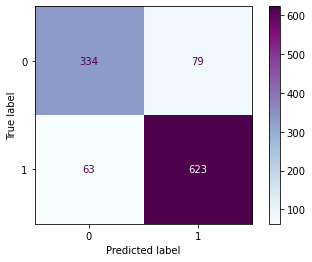

In [14]:
class_metrics(X_train, y_train, X_test,y_test, grid_model)

The Naive Baise model shows an improvemnt in all metrics over the KNN model but still doesnt reach the 92/91% accuracy of the Logistic regression model

### Voting Classifer: Knn, Logistic Regression, MN Naive Baise
___

In [15]:
#Knn scaled pipeline
knn_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=7))
])


#logistic regression scaled pipeline.
lr_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(C=0.1, penalty='l2'))
])

#Create our voting classifer with knn
# logisitic regression, and MN Naive Baise models.
vote = VotingClassifier([
    ('knn_pipe', knn_pipe),
    ('lr_pipe', lr_pipe),
    ('nb', MultinomialNB(alpha=0, fit_prior=True))
])

# Fit our training data to our Voting classifer.
vote.fit(X_train, y_train)

VotingClassifier(estimators=[('knn_pipe',
                              Pipeline(steps=[('ss', StandardScaler()),
                                              ('knn',
                                               KNeighborsClassifier(n_neighbors=7))])),
                             ('lr_pipe',
                              Pipeline(steps=[('ss', StandardScaler()),
                                              ('lr',
                                               LogisticRegression(C=0.1))])),
                             ('nb', MultinomialNB(alpha=0))])

Train Accuracy - Correctly Classified: 0.92
Test Accuracy - Correctly Classified: 0.9

Train Sensitivity - True Positvive Rate: 0.95
Test Sensitivity - True Positvive Rate: 0.94

Train Specificity - True Negative Rate: 0.86
Test Specificity - True Negative Rate: 0.83

Confustion Matrix of Test Data


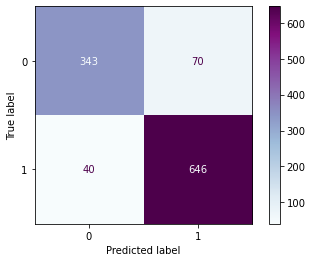

In [16]:
class_metrics(X_train, y_train, X_test,y_test, vote)

The Above voting classifer has improved all three of our metrics. Throughout this initial process we have had trouble imporving our sensitivity since our target class is unevenly balanced. We should note that our negative class those that vote democrat is 62% of our target, and our positive class vote republican, has 37% of our target data this value reflects the split of regestered democrats to republucan in the state of california. Lets see if adding more relivant features help our model better predict who will vote for each gubernatorial candidate.

### Lets include more relevant features to our model to improve performance.

To imporove our model we decided to incoorporate, home ownership, and party indentifier into our model to see it these would imporve our classification metrics.

In [17]:
# Including new feature dataframe, index is voter ID
df_2 = pd.read_csv('../Data/2018_gov_features.csv', index_col='Unnamed: 0')
df_2.head()

,dist,ownhome,pid3,gender,age,educ,race,faminc,marstat,newsint,approval_gov,ideo5,voted_gov
392782,19,Other,Democrat,Female,54,4-Year,White,50k - 60k,Single / Never Married,Most of the time,Strongly Approve,Liberal,[Democrat / Candidate 1]
392786,52,Rent,Democrat,Female,28,Some College,White,20k - 30k,Single / Never Married,Most of the time,Strongly Approve,Liberal,[Democrat / Candidate 1]
392800,49,Own,Other,Male,86,Post-Grad,White,120k - 150k,Widowed,Most of the time,Strongly Disapprove,Very Conservative,[Republican / Candidate 2]
392832,36,Own,Republican,Male,80,Some College,White,20k - 30k,Widowed,Most of the time,Strongly Disapprove,Conservative,[Republican / Candidate 2]
392860,36,Own,Independent,Male,83,4-Year,White,Prefer not to say,Married,Most of the time,Strongly Disapprove,Conservative,[Republican / Candidate 2]


In [18]:
# Only include those who voted for democrat or republican candadate.
df_2 = df_2[(df_2['voted_gov'] == '[Democrat / Candidate 1]') | (df_2['voted_gov'] == '[Republican / Candidate 2]')]
df_3 = df_2.copy()

In [19]:
# List of columns that will be dummified
cata_columns = ['dist', 'ownhome', 'pid3', 'gender', 'educ', 'race', 
                'faminc', 'marstat', 'newsint', 'approval_gov','ideo5']


# Dummify catagorical columns
df_2 = pd.get_dummies(df_2, columns=cata_columns, drop_first=True)

In [20]:
# Change the catagorical values in the target feature to "1" or "0" denoting a positive or negative class
df_2['voted_gov'] = df_2['voted_gov'].map({'[Democrat / Candidate 1]': 1, '[Republican / Candidate 2]': 0})

#Changing our target column to better indicate target: "voted_democrat"
df_2.rename(columns={'voted_gov': 'voted_democrat'}, inplace=True)

In [21]:
# Create X and y variables
X = df_2.drop(columns=['voted_democrat'])
y = df_2['voted_democrat']

# Train Test split our X and y Variables.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [22]:
# scale our data for a logistic regression model
lr_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression()),
])

# find the optimal hyperparameters.
pipe_params ={
    'lr__C' : [1.0, 0.1, 0.01, 0.001],
    'lr__penalty': ['l1','l2','none'],

}

# Gridsearch using the specified hyper parameters.
grid_model = GridSearchCV(
    lr_pipe,
    pipe_params,
    cv = 5,
    n_jobs = -1,
    verbose = 2
)

# Fit our training data to the Grisearch.
grid_model.fit(X_train, y_train)
print(grid_model.best_params_)
print(grid_model.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'lr__C': 0.1, 'lr__penalty': 'l2'}
Pipeline(steps=[('ss', StandardScaler()), ('lr', LogisticRegression(C=0.1))])


Train Accuracy - Correctly Classified: 0.94
Test Accuracy - Correctly Classified: 0.92

Train Sensitivity - True Positvive Rate: 0.96
Test Sensitivity - True Positvive Rate: 0.95

Train Specificity - True Negative Rate: 0.9
Test Specificity - True Negative Rate: 0.88

Confustion Matrix of Test Data


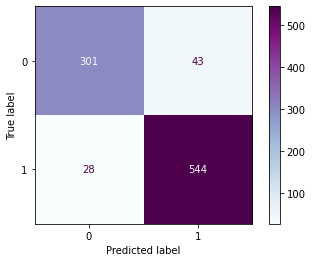

In [23]:
class_metrics(X_train, y_train, X_test,y_test, grid_model)

We can see above that compaired with our previous logistic Regression model, that adding our extra features caused our training data to be slighly more overfit, However this model classified the negative classes better. an imporvment of 3% points in specificity. 

In [24]:
# Create a pipleline to scale our data fro KNN Classification.
lr_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier()),
])


# find the optimal hyperparameters.
pipe_params ={
    'knn__n_neighbors' : [1 ,2, 3, 4, 5, 6, 7],
}

# Create a gridsearch model to find our Hyperparameters
grid_model = GridSearchCV(
    lr_pipe,
    pipe_params,
    cv = 5,
    n_jobs = -1,
    verbose = 2
)


# Fit our training data to the Grisearch.
grid_model.fit(X_train, y_train)
print(grid_model.best_params_)
print(grid_model.best_estimator_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'knn__n_neighbors': 7}
Pipeline(steps=[('ss', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=7))])


Train Accuracy - Correctly Classified: 0.87
Test Accuracy - Correctly Classified: 0.81

Train Sensitivity - True Positvive Rate: 0.93
Test Sensitivity - True Positvive Rate: 0.9

Train Specificity - True Negative Rate: 0.76
Test Specificity - True Negative Rate: 0.66

Confustion Matrix of Test Data


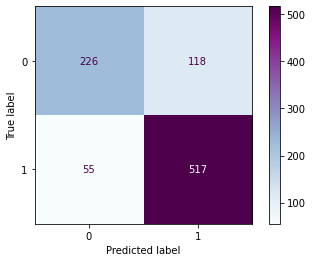

In [25]:
class_metrics(X_train, y_train, X_test,y_test, grid_model)

Adding the extra two features decreased our accuracy from 85% to 81% in our test set, with a slight imporovment to specificity. 66% to 75% in our test set.

In [26]:
# Listing our Naive Baise hyperparameters.
grid_params ={
    'alpha': list(np.linspace(0.0, 1.0, num=5)),
    'fit_prior': [True, False]
}

# Fit our training data to the Grisearch.
grid_model = GridSearchCV(
    MultinomialNB(),
    grid_params,
    cv = 5,
    n_jobs = -1,
    verbose = 2
)

# Fit our training data to the Grisearch.
grid_model.fit(X_train, y_train)
print(grid_model.best_params_)
print(grid_model.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'alpha': 0.5, 'fit_prior': True}
MultinomialNB(alpha=0.5)


Train Accuracy - Correctly Classified: 0.91
Test Accuracy - Correctly Classified: 0.92

Train Sensitivity - True Positvive Rate: 0.93
Test Sensitivity - True Positvive Rate: 0.94

Train Specificity - True Negative Rate: 0.88
Test Specificity - True Negative Rate: 0.89

Confustion Matrix of Test Data


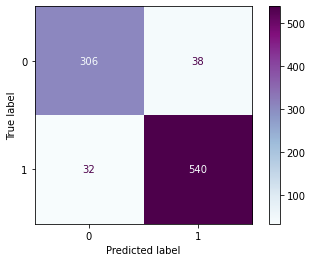

In [27]:
class_metrics(X_train, y_train, X_test,y_test, grid_model)

Adding the two new features increases our accuracy from 87% to ~91% of all the previous models adding these new features has increased our Naive Bayes model the most. Let us know put all of these models in a voting classifer and see how we cause each of these models in ensemble learning.

### Voting Classifer with Added Features.

In [28]:
#Knn scaled pipeline
knn_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])


#logistic regression scaled pipeline.
lr_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(C=0.01, penalty='l2'))
])

#instantiate a voting classifer with KNN, LR, and MN Naive Baise.
vote = VotingClassifier([
    ('knn_pipe', knn_pipe),
    ('lr_pipe', lr_pipe),
    ('nb', MultinomialNB(alpha=1, fit_prior=True))
    
])

#Fit Voting Classifer.
vote.fit(X_train, y_train)

VotingClassifier(estimators=[('knn_pipe',
                              Pipeline(steps=[('ss', StandardScaler()),
                                              ('knn',
                                               KNeighborsClassifier())])),
                             ('lr_pipe',
                              Pipeline(steps=[('ss', StandardScaler()),
                                              ('lr',
                                               LogisticRegression(C=0.01))])),
                             ('nb', MultinomialNB(alpha=1))])

Train Accuracy - Correctly Classified: 0.93
Test Accuracy - Correctly Classified: 0.93

Train Sensitivity - True Positvive Rate: 0.95
Test Sensitivity - True Positvive Rate: 0.96

Train Specificity - True Negative Rate: 0.89
Test Specificity - True Negative Rate: 0.88

Confustion Matrix of Test Data


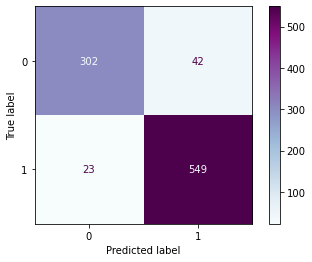

In [29]:
class_metrics(X_train, y_train, X_test,y_test, vote);

This is by far our best model ensemble learning has correctly classifed 1 more false positive, and 5 more false negatives than our logistic regression model which shows to me that our logistic regression model is doing the heavy lifing here. This is good beacuase we have a good model that we can interpret. 

#### Lets look at coefficients.
Lets take a look into the coefficients of our model and see what determines a voter to vote democrat or republican, also lets look into what factors make up a moderate voter.

In [30]:
# Fit a Logistic Regression model with hyperparameters from voting classifer.
lr = LogisticRegression(max_iter=10_000, C=0.01, penalty='l2')
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.9173643975245722

In [31]:
# Create a dataframe that houses the Coefficients of the logistic model.
coeffs = pd.DataFrame(lr.coef_[0], index=X.columns, columns=['coeffs']).rename({'coeffs':'Coefficients'})

#Rename Title from Coeffs, to Coefficients.
coeffs.rename(columns={"coeffs": "Coefficients"}, inplace=True)

# Sort coefficients, by feature importances.
coeffs.sort_values(by= 'Coefficients', ascending=False, inplace=True)
coeffs.iloc[:10]

,Coefficients
ideo5_Liberal,0.664243
approval_gov_Strongly Approve,0.617504
ideo5_Very Liberal,0.565472
race_Black,0.179883
ownhome_Rent,0.137918
ideo5_Not Sure,0.078473
ideo5_Moderate,0.077715
faminc_10k - 20k,0.069134
educ_Some College,0.056625
approval_gov_Never Heard / Not Sure,0.051226


Here you can see the main factors that determine if someone will vote for the positive class democrat. Notice that For voting for the democratic candidate political ideology is more important than party affiliation. Black People generally vote Democratic, as well as renters, and college graduates.

In [32]:
coeffs.iloc[-10:]

,Coefficients
gender_Male,-0.095727
pid3_Other,-0.112037
marstat_Married,-0.125181
ownhome_Own,-0.151742
race_White,-0.179640
approval_gov_Disapprove / Somewhat Disapprove,-0.244209
pid3_Independent,-0.291938
ideo5_Very Conservative,-0.399013
pid3_Republican,-1.117950
approval_gov_Strongly Disapprove,-1.396247


Looking at the chart above of our top 10 coeffients that predict the negative class "voting republican. Notice here that party affiliation has a stronger impact than ideology. With the stong disapproval of the govenor, home ownership, race being white aslo play an important role if the person will vote for the republican candidate.

#### Lets take a look at the moderates.
To determine who is a moderate we will use all the predictions from the logistic regression model where the predict probability was less than 60% for both positive and negative classes.

In [33]:
probas = pd.DataFrame(lr.predict_proba(X), index=X.index)
mod_index = probas[(probas[1] < .60) & (probas[0] < .60)]

# create a moderate dataframe from our original dataframe with
# just indexes from those with probability of either class
# under 65%
moderate_df = df_3.loc[mod_index.index]

These are the selct 301 that the model had lower than 60% probabality to classify, lets take a look into them and see their metrics.

In [34]:
moderate_df['voted_gov'].value_counts(normalize=True)

[Republican / Candidate 2]    0.644518
[Democrat / Candidate 1]      0.355482
Name: voted_gov, dtype: float64

In [35]:
moderate_df['ideo5'].value_counts(normalize=True)

Moderate             0.488372
Conservative         0.338870
Very Conservative    0.059801
Not Sure             0.039867
Liberal              0.039867
Very Liberal         0.033223
Name: ideo5, dtype: float64